### 미니 경진대회

폐기물 사진 분류

### EDA
간단한 데이터 탐색을 진행한다.

In [1]:
import os
import numpy as np
import cv2
import shutil
import pandas as pd
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from glob import glob
from keras import layers, models
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [15]:
# Train/Test 별 이미지 가로 세로 정보 확인하기 
train_path = glob(r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN\*\*")

train_data = []
for path in train_path:
    row_data = []
    
    path = path.replace(r"\\", "/")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, c = img.shape
    row_data.append(path)
    row_data.append(h)
    row_data.append(w)
    train_data.append(row_data)


In [24]:
train_df = pd.DataFrame(train_data, columns=['path', 'height', 'width'])
print(train_df['height'].max(), train_df['height'].min())
print(train_df['width'].max(), train_df['width'].min())
train_df

383 69
600 51


path  height  width
0      C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     242    208
1      C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     183    275
2      C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     183    275
3      C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     209    242
4      C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     186    271
...                                                  ...     ...    ...
22559  C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     225    225
22560  C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     240    180
22561  C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     225    225
22562  C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     225    225
22563  C:\Users\OWNER\Desktop\module38_dataset\TRAIN\...     225    225

[22564 rows x 3 columns]

In [19]:
test_path = glob(r"C:\Users\OWNER\Desktop\module38_dataset\TEST\*\*")

test_data = []
for path in test_path:
    row_data = []
    
    path = path.replace(r"\\", "/")
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, c = img.shape
    row_data.append(path)
    row_data.append(h)
    row_data.append(w)
    test_data.append(row_data)

In [25]:
test_df = pd.DataFrame(test_data, columns=['path', 'height', 'width'])
print(test_df['height'].max(), test_df['height'].min())
print(test_df['width'].max(), test_df['width'].min())
test_df

1500 94
1460 87


path  height  width
0     C:\Users\OWNER\Desktop\module38_dataset\TEST\O...     227    223
1     C:\Users\OWNER\Desktop\module38_dataset\TEST\O...     225    225
2     C:\Users\OWNER\Desktop\module38_dataset\TEST\O...     225    225
3     C:\Users\OWNER\Desktop\module38_dataset\TEST\O...     225    225
4     C:\Users\OWNER\Desktop\module38_dataset\TEST\O...     225    225
...                                                 ...     ...    ...
2508  C:\Users\OWNER\Desktop\module38_dataset\TEST\R...     183    275
2509  C:\Users\OWNER\Desktop\module38_dataset\TEST\R...     177    284
2510  C:\Users\OWNER\Desktop\module38_dataset\TEST\R...     225    225
2511  C:\Users\OWNER\Desktop\module38_dataset\TEST\R...     198    254
2512  C:\Users\OWNER\Desktop\module38_dataset\TEST\R...    1500   1460

[2513 rows x 3 columns]

이미지 데이터 총 정리

|Dataset|총 데이터 건수|가로 최대 픽셀|가로 최소 픽셀|세로 최대 픽셀|세로 최소 픽셀|
|---|---|---|---|---|---|
|Train|22564|383px|69px|600px|51px|
|Test|2513|1500px|94px|1460px|87px|

학습 이후 Feature Engineering이 필요한 시점에서 이 정보들을 활용한다.

### 각 클래스 별 분포 확인
클래스 별로 분포를 확인한다.

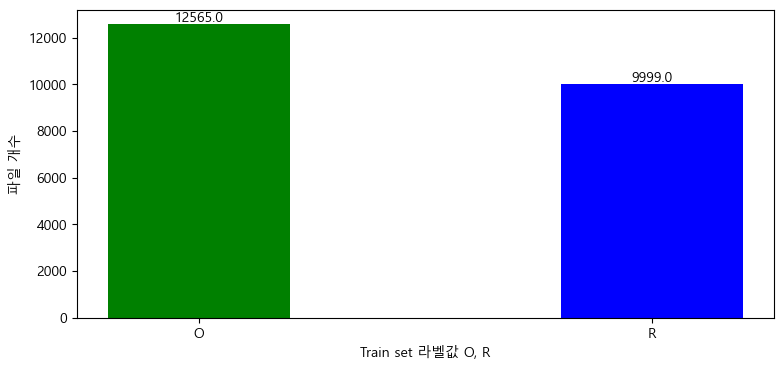

In [30]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob(r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN\*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ['O', 'R']

plt.figure(figsize=(9,4))
bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue"]) # barplot
plt.xlabel("Train set 라벨값 O, R")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)
    
plt.show()

약 2500장 가량의 차이를 확인. 데이터를 지우기보단 별도의 폴더에 따로 옮겨둔다.

In [51]:
train_path = glob(r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN\O\*")
backup_path = r"C:\Users\OWNER\Desktop\train_backup"

# 2565장을 옮김으로 10000:9999로 분포를 균등하게 한다.
for i in range(2565):
    filename = train_path[i][train_path[i].rfind("\\")+1 : ]
    origin_path = os.path.join(r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN\O", filename)
    backup_file_path = os.path.join(backup_path, filename)
    
    shutil.move(origin_path, backup_file_path)

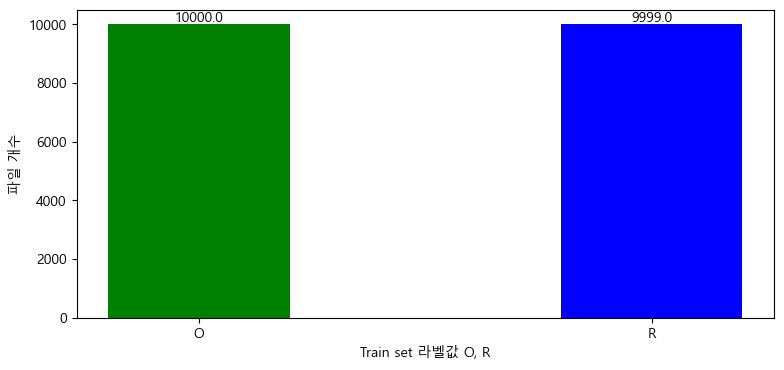

In [52]:
# 분포 재확인
train_path = glob(r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN\*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ['O', 'R']

plt.figure(figsize=(9,4))
bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue"]) # barplot
plt.xlabel("Train set 라벨값 O, R")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)
    
plt.show()

### 학습 데이터 준비

TEST에 들어있는 데이터들은 학습 후 테스팅에 사용하고, 검증셋의 경우 증강기의 옵션을 활용하여 split한다.

In [2]:
batch_size = 32
input_shape = (224, 224, 3)
epochs = 100
learning_rate = 0.001

In [3]:
train_path = r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN"
test_path = r"C:\Users\OWNER\Desktop\module38_dataset\TEST"

train_generator = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.15,
    fill_mode= 'reflect',
    rotation_range=30,
    validation_split=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

test_generator = ImageDataGenerator(
    rescale=1./255.
)

train_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    subset="training"
)

valid_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    subset="validation"
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    shuffle=False
)

Found 16000 images belonging to 2 classes.
Found 3999 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


### Base Line modeling
기본적인 CNN모델로 빌드한다.

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu", input_shape=input_shape))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate), 
    loss="binary_crossentropy", 
    metrics=['acc']
)

els = EarlyStopping(monitor="val_acc", mode="max", patience=5)
check = ModelCheckpoint(monitor="val_acc", mode="auto", filepath="./mini_hack/transfer/Densenet.h5", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=3)
logger = CSVLogger("./mini_hack/transfer/Densenet.csv")

model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[els, check, reduce_lr, logger])

Epoch 1/100
500/500 [==============================] - 198s 395ms/step - loss: 0.4785 - acc: 0.7781 - val_loss: 0.5046 - val_acc: 0.7369 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 121s 243ms/step - loss: 0.4343 - acc: 0.8038 - val_loss: 0.5049 - val_acc: 0.7517 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 126s 252ms/step - loss: 0.4113 - acc: 0.8167 - val_loss: 0.4642 - val_acc: 0.7834 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 136s 271ms/step - loss: 0.3970 - acc: 0.8254 - val_loss: 0.4636 - val_acc: 0.7784 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 131s 261ms/step - loss: 0.3830 - acc: 0.8324 - val_loss: 0.4233 - val_acc: 0.8072 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 128s 255ms/step - loss: 0.3636 - acc: 0.8443 - val_loss: 0.4260 - val_acc: 0.8162 - lr: 0.0010
Epoch 7/100
500/500 [==============================] - 132s 264ms/step - loss: 0.3472 - acc: 0.8521 

train acc : val acc 가 0.90:0.87 정도로 과적합은 일어나지 않았음을 판단할 수 있다. 평가 지표를 출력해보자.

### 평가 지표 산출

In [76]:
model = load_model("./mini_hack/base_model.h5")

y_true = test_dataset.classes
y_pred = []

for prediction in model.predict(test_dataset, verbose=0):
    if prediction > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [77]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1401
           1       0.92      0.88      0.90      1112

    accuracy                           0.91      2513
   macro avg       0.92      0.91      0.91      2513
weighted avg       0.91      0.91      0.91      2513



f1-score또한 괜찮은 지표를 출력하고 있음을 확인할 수 있다. 임의의 데이터에 대한 예측을 진행해보자.

### 100개의 임의 데이터에 대한 에측
해당 데이터의 경우 1~50까지는 정상, 51~100까지는 폐기물이다.

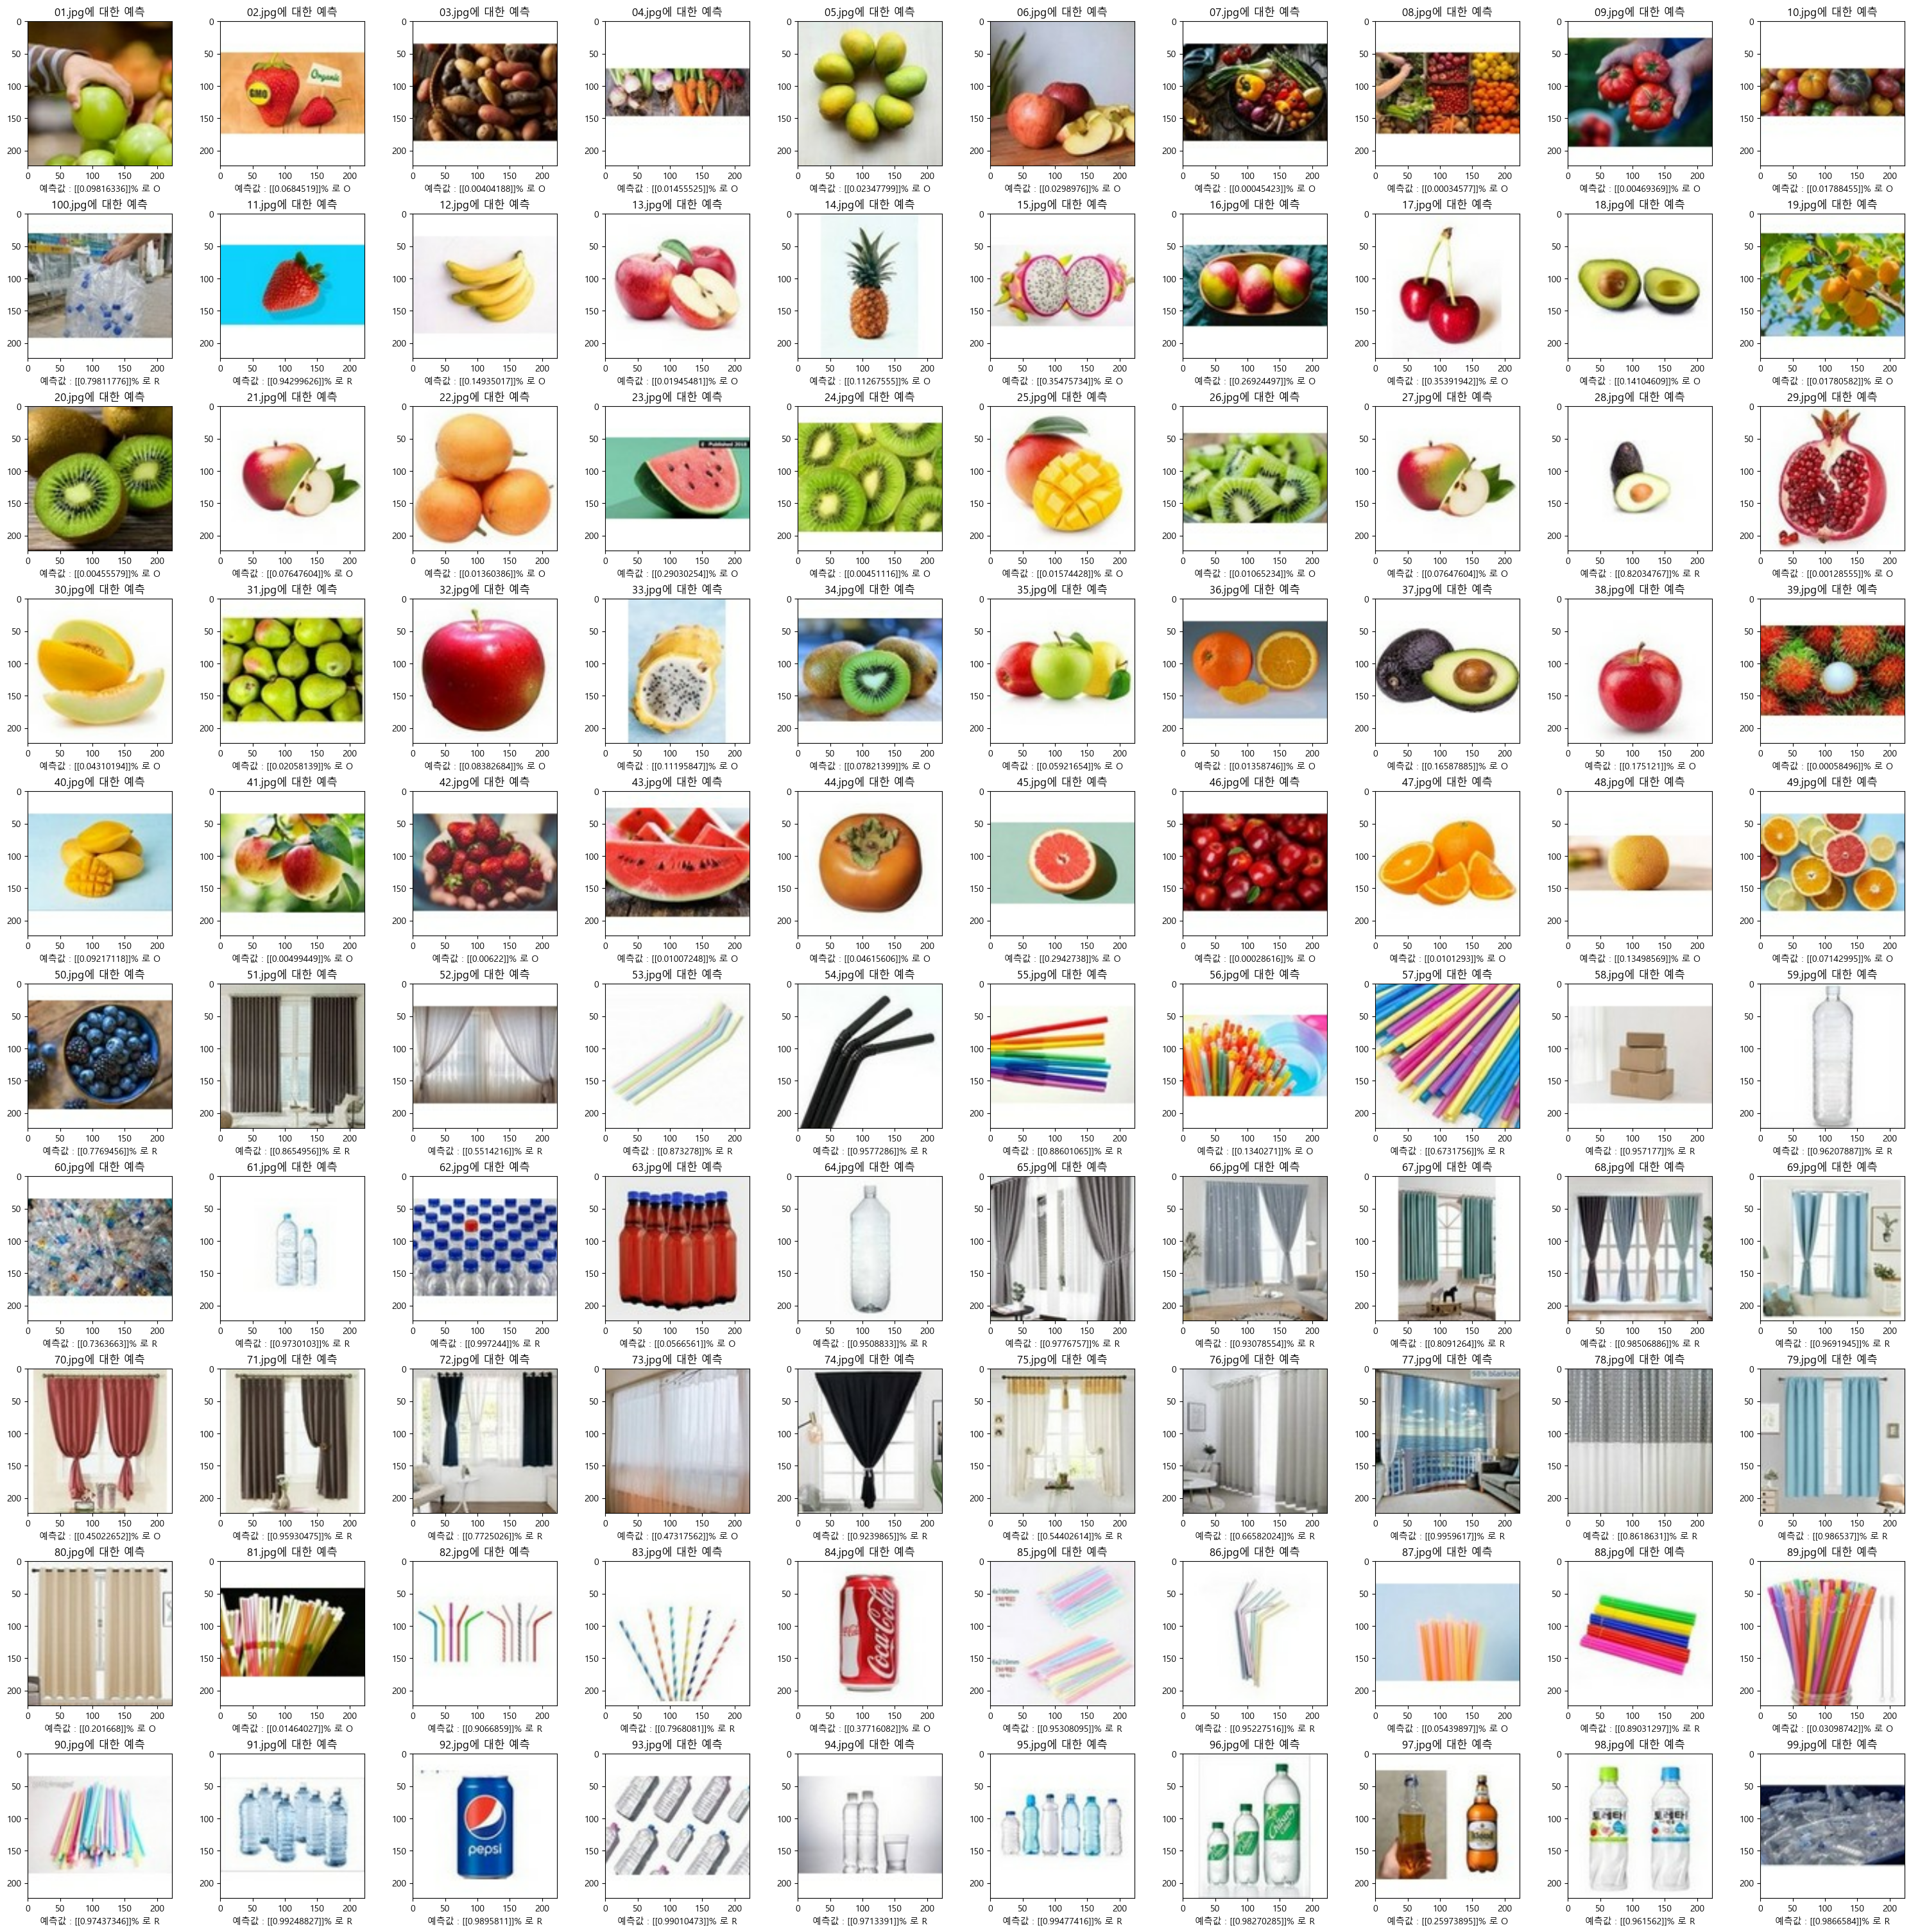

In [106]:
import numpy as np
import warnings
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore") # 경고 문구 무시하는 부분입니다. 필요하시면 다른 곳에서 사용하셔도 됩니다.

def read_image(path):                                   
    gfile = tf.io.read_file(path)                       
    image = tf.io.decode_image(gfile, dtype=tf.float32) 
    return image

model = load_model("./mini_hack/base_model.h5") # 모델 경로 수정해주세요 !
labels = {0 : "O", 1 : "R"} # Train 폴더 내부에 있는 순서대로 작성해주시면 됩니다.
                            # ex. Train폴더 밑에 black rot, healthy, black spot 순서대로 있다 = {0 : 'black rot', 1 : "healthy", 2 : "black spot"} <= 이렇게 작성하시면 됩니다 !
data_path = glob("C:/Users/OWNER/Desktop/OR_TEST/*") # 테스트 할 이미지가 들어있는 경로로 수정해주세요. 
                                                     # 현재 경로가 의미하는 것은 C -> 사용자 -> 배경화면 -> OR_TEST -> 모든 파일(*)을 의미합니다 !
                                                     # 이미지 전체를 지정하는 과정이라고 보시면 되겠습니다.
fig, axes = plt.subplots(10, 10, constrained_layout=True, figsize=(30, 30)) # 10행 10열짜리 빈 그래프를 생성합니다. 
fig.subplots_adjust(hspace=0.5,wspace=0.3) # 10행 10열의 각 열자리에 들어가는 그래프들 사이에 공백을 넣습니다.

i = 0 
cnt = 0 

data_path = np.random.shuffle(data_path)
for test_no in range(0, 100):
    path = data_path[test_no] # 각 이미지 경로를 가져와서
    filename = path[path.rfind("\\") + 1 : ] # 이미지 이름 부분만 추출합니다.
    img = read_image(path) # 위에서 정의한 함수로 이미지를 읽고
    img = tf.image.resize(img, (224, 224)) # 모델의 input사이즈로 형상을 변환합니다.

    image = np.array(img) # 이미지를 배열의 형태로 변환하고
    image = image[:, :, :]
    test_image = image[tf.newaxis, ...]
    pred = model.predict(test_image, verbose = 0) # 예측을 진행합니다.
    if pred > 0.5: # 현재 이진 분류(저는 출력층 Dense에서 1개를 sigmoid로 활성화했습니다)이기에 아래와 같은 과정을 진행하지만
        num = 1
    else:
        num = 0
        
    # num = np.argmax(pred) # 다중 분류(혹은 이진분류임에도 출력층 Dense에서 2개를 softmax로 활성화했다면)일 땐 이 코드를 사용하셔야 합니다 !
    
    axes[i, cnt].imshow(image, 'gray') # 각 위치에 맞는 그래프를 그립니다.
    axes[i, cnt].set_title(f"{filename}에 대한 예측") # 제목의 경우 이미지의 원래 라벨값을 의미하고
    axes[i, cnt].set_xlabel(f"예측값 : {pred}% 로 {labels[num]}") # x축에 예측된 라벨값을 적음으로 원래 라벨값과 예측값을 위아래로 확인할 수 있습니다.
    
    cnt += 1
    if cnt%10 == 0:
        cnt = 0
        i += 1

### 모델 수정
새로운 데이터의 대부분을 잘 예측하는 듯 하나, 추가적인 개선이 필요할 듯 하다. 전이학습을 이용하자.

### 증강기 재설정

In [8]:
train_path = r"C:\Users\OWNER\Desktop\module38_dataset\TRAIN"
test_path = r"C:\Users\OWNER\Desktop\module38_dataset\TEST"

input_shape = (224, 224, 3)

train_generator = ImageDataGenerator(
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.15,
    fill_mode= 'constant',
    cval=0.2,
    rotation_range=30,
    validation_split=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

test_generator = ImageDataGenerator(
    rescale=1./255.
)

train_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    subset="training"
)

valid_dataset = train_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    subset="validation"
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    batch_size=batch_size,
    target_size=input_shape[:2],
    color_mode="rgb",
    class_mode="binary",
    shuffle=False
)

Found 14000 images belonging to 2 classes.
Found 5999 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [13]:
def get_model(model):
    params = {
        'input_shape' : input_shape, 
        'include_top': False,
        'weights':'imagenet',
        'pooling':'avg',
        'classes':2
    }
    
    pretrained_model = model(**params)
    
    for pretrained_layer in pretrained_model.layers[:-3]:
        pretrained_layer.trainable = False
    
    inputs = pretrained_model.input
    x = tf.keras.layers.BatchNormalization()(pretrained_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
    
    return model

def fit_eff():
    model_check = ModelCheckpoint(filepath = "./mini_hack/transfer2/newnew.{epoch:02d}.h5", monitor = "val_acc", save_best_only = True, mode = "auto")
    reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3, mode = "min")
    early_stop = EarlyStopping(monitor = "val_acc", patience = 5, mode = "max")
    logger = CSVLogger('./mini_hack/transfer2/newnew.csv')
    
    model = get_model(tf.keras.applications.DenseNet201)
    model.fit(
        train_dataset, 
        epochs = epochs, 
        validation_data = valid_dataset, 
        callbacks=[model_check, reduce_lr, early_stop, logger]
    )

In [14]:
fit_eff()

Epoch 1/100
438/438 [==============================] - 258s 573ms/step - loss: 0.2500 - acc: 0.9139 - val_loss: 0.2282 - val_acc: 0.9213 - lr: 0.0010
Epoch 2/100
438/438 [==============================] - 344s 786ms/step - loss: 0.1523 - acc: 0.9422 - val_loss: 0.2609 - val_acc: 0.9075 - lr: 0.0010
Epoch 3/100
438/438 [==============================] - 171s 390ms/step - loss: 0.1340 - acc: 0.9479 - val_loss: 0.2301 - val_acc: 0.9212 - lr: 0.0010
Epoch 4/100
438/438 [==============================] - 716s 2s/step - loss: 0.1180 - acc: 0.9557 - val_loss: 0.2599 - val_acc: 0.9073 - lr: 0.0010
Epoch 5/100
438/438 [==============================] - 278s 637ms/step - loss: 0.0903 - acc: 0.9659 - val_loss: 0.2236 - val_acc: 0.9237 - lr: 1.0000e-04
Epoch 6/100
438/438 [==============================] - 1088s 2s/step - loss: 0.0744 - acc: 0.9716 - val_loss: 0.2312 - val_acc: 0.9215 - lr: 1.0000e-04
Epoch 7/100
438/438 [==============================] - 1183s 3s/step - loss: 0.0695 - acc: 0.9742